In [136]:
import json
import jieba
import os
from tqdm import tqdm_notebook

names = json.load(open(r'userdict.json','r', encoding='utf-8'))
for name in names :
    for alias_name in name:
        jieba.add_word(alias_name, tag='nc') #将人物别名添加到jieba中，防止误分词

In [137]:
def stopwords(filename):
    # 加载停用词表
    with open(filename, 'r', encoding='utf-8') as f:
        stopwords = [word.strip('\n') for word in f.readlines()]
    return stopwords

stopwords = stopwords(r'stopwords.txt') # 获取全部停用词

In [138]:
def process(filename):
    #分词
    
    with open(filename, 'rb') as f:
        content = f.read()
        content = content.decode('utf-8', 'ignore').split('\n')
        result = [] #  存储每一章节的词
        for line in content:
            jieba_words = jieba.cut(line, cut_all=False)
            words = [] # 存储每个段落的词
            for word in jieba_words:
                if word in stopwords:
                    continue
                if len(word) <= 1:
                    continue
                words.append(word)
            result.append(words)
    return result

#process(os.path.join('红楼梦','1_第一回　甄士隐梦幻识通灵　贾雨村风尘怀闺秀.txt'))             

In [139]:
#j将所有的章节分词
all_chapters = os.listdir('红楼梦')
results = {} # 存储分词结果
for chapter in tqdm_notebook(all_chapters):
    index = int(chapter.split('_')[0])
    filename = os.path.join('红楼梦', chapter)
    results[index] =  process(filename)

#results

A Jupyter Widget

In [140]:
import itertools


# 统计每个词出现的频率表
artical_words_dict = {} # 存储所有章节中每个词出现的频率
chapters_words_dict = {} # 存储单一章节中每个词出现的频率

for index in results:
    chapter_words_dict = {}
    chapter_words_list = list(itertools.chain.from_iterable(results[index]))
    for word in chapter_words_list:
        if word not in chapter_words_dict:
            chapter_words_dict[word] = 0
        if word not in artical_words_dict:
            artical_words_dict[word] = 0
        
        chapter_words_dict[word] += 1
        artical_words_dict[word] += 1
        
        chapters_words_dict[index] = chapter_words_dict
        
sort_results_list = [result[1] for result in sorted(
    zip(artical_words_dict.values(), artical_words_dict.keys()), reverse=True)] # 对词频进行由高到低的排序

#sort_results

In [141]:
import re


all_names = [] #存储所有的别名
for name in names :
    for alias_name in names[name]:
        all_names.append(alias_name)
        
# 将名字从词频列表中删除
to_delete = [] # 待删除的名字
for word in tqdm_notebook(sort_results_list):
    for name in all_names:
        pattern = re.compile('(.*){}(.*)'.format(name))
        t = re.search(pattern, word)
        if t:
            to_delete.append(word)
            break

# 删除
for x in to_delete:
    sort_results_list.remove(x)
 
V = 2000 # 选择前 V 个词语的词频作为一章节的特征
word_list = sort_results_list[:V]
#word_list

A Jupyter Widget

In [142]:
import numpy as np

features = np.zeros((len(chapters_words_dict), V)) # 生成一个 120*2000 的 0 矩阵，每一行对应一章节的特征。
# 遍历每个章节的 word dict
for index in chapters_words_dict:
    # 章节 word dict
    word_dict = chapters_words_dict[index]
    # 遍历每个词语，并改变相应位置的值为该词语出现次数
    for j, word in enumerate(word_list):
        try:
            features[index, j] = word_dict[word]
        except:
            pass    
features /= features.max(axis=0) #归一化

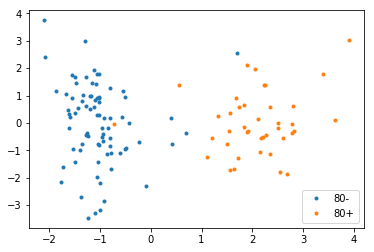

In [143]:
from sklearn.decomposition.pca import PCA
from matplotlib import pyplot as plt
%matplotlib inline

features = PCA(n_components=2).fit_transform(features) # PCA降维
plt.plot(features[: 80, 0].flatten(), features[: 80, 1].flatten(), '.')
plt.plot(features[80:, 0].flatten(), features[80:, 1].flatten(), '.')
plt.legend(['80-', '80+'])

In [144]:
# 绘制人物关系

# 将所有人名两两全排列
count = {}
for comb in itertools.product(names.keys(), repeat=2):
    count['_'.join(comb)] = 0

# 统计同意章节共同出现的次数
for para_word_list in tqdm_notebook(list(itertools.chain.from_iterable(results.values()))):
    para_name_list = []
    for name in names:
        tmp = set(names[name]).intersection(para_word_list) # 判断人名是否在该章节出现过
        if len(tmp)>0:
            para_name_list.append(name)
    para_name_list = set(para_name_list) # 去重
    for comb in itertools.combinations(para_name_list, 2): # 每一章节出现的人名两两组合
        count['_'.join(comb)] += 1 # 

A Jupyter Widget

In [145]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
import networkx as nx

# 激活 Plotly notebook 模式，方便离线绘图
init_notebook_mode(connected=True)

# 创建 Graph
G = nx.Graph()
# 所有节点
nodes = []
# 所有边
edges = []
# 统计所有名字的组合
for comb in itertools.combinations(names.keys(), 2):
    # 两个名字一起出现的次数
    total = count['{}_{}'.format(comb[0], comb[1])] + count['{}_{}'.format(comb[1], comb[0])]
    # 如果一起出现了，才保存
    if total>0:
        edges.append((comb[0], comb[1], { 'weight': total}))
        nodes.append(comb[0])
        nodes.append(comb[1])
# 去除重复节点
nodes = list(set(nodes))
# 添加节点和边
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# 节点对应到图上的坐标 (x, y)
pos=nx.spring_layout(G)

In [146]:
# 绘制边的轨迹
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

# 遍历每一条边，根据上文获得的每一个节点的坐标，连接两个节点
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# 绘制点
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

# 遍历每一个点
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [154]:
# 遍历邻接列表，对应了 节点->一条边的另一个节点和权重
for node, adjacencies in enumerate(G.adjacency()):
    # 把所有边的次数累加，据此对每一个点添加颜色，出现次数越多颜色越深（除以 5000 防止超出范围）
    node_trace['marker']['color'] += tuple(
        [sum([adjacencies[1][name]['weight'] for name in adjacencies[1]])/5000])
    node_info = adjacencies[0]
    # 每一个节点添加标注信息（名字）
    node_trace['text'] += tuple([node_info])

In [156]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>红楼梦人物关系网络图',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text=None,
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig, filename='红楼梦人物关系网络图')